# Проект 4 - Классификация


Учебный, в рамках курса Data Science от Skillfactory

In [1]:
# импортируем необходимые библиотекиюю
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df

age          job  marital  education default       balance housing  \
0       59       admin.  married  secondary      no   2 343,00 $      yes   
1       56       admin.  married  secondary      no      45,00 $       no   
2       41   technician  married  secondary      no   1 270,00 $      yes   
3       55     services  married  secondary      no   2 476,00 $      yes   
4       54       admin.  married   tertiary      no     184,00 $       no   
...    ...          ...      ...        ...     ...           ...     ...   
11157   33  blue-collar   single    primary      no       1,00 $      yes   
11158   39     services  married  secondary      no     733,00 $       no   
11159   32   technician   single  secondary      no      29,00 $       no   
11160   43   technician  married  secondary      no         0  $       no   
11161   34   technician  married  secondary      no         0  $       no   

      loan   contact  day month  duration  campaign  pdays  previous poutcome  \
0       no   unknown    5   may      1042         1     -1         0  unknown   
1       no   unknown    5   may      1467         1     -1         0  unknown   
2       no   unknown    5   may      1389         1     -1         0  unknown   
3       no   unknown    5   may       579         1     -1         0  unknown   
4       no   unknown    5   may       673         2     -1         0  unknown   
...    ...       ...  ...   ...       ...       ...    ...       ...      ...   
11157   no  cellular   20   apr       257         1     -1         0  unknown   
11158   no   unknown   16   jun        83         4     -1         0  unknown   
11159   no  cellular   19   aug       156         2     -1         0  unknown   
11160  yes  cellular    8   may         9         2    172         5  failure   
11161   no  cellular    9   jul       628         1     -1         0  unknown   

      deposit  
0         yes  
1         yes  
2         yes  
3         yes  
4         yes  
...       ...  
11157      no  
11158      no  
11159      no  
11160      no  
11161      no  

[11162 rows x 17 columns]

In [3]:
# исследуйте данные на предмет пропусков...
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Мы видим 70 позиций в графе 'unknown'...

### Задание 3

In [5]:
# преобразуйем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# напишем функцию по обратотке строки с данными о балансе...
def replacer(arg):
    numbr = str(arg).replace(' $','')
    numbr = numbr.replace(',','.')
    numbr = numbr.replace(' ','')
    return numbr

# пеобразуем данные в признаке 'balance'
df['balance'] = df['balance'].apply(replacer)

### Задание 4

In [6]:
# обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median()).astype('float')
df['balance'] = df['balance'].fillna(df['balance'].median())

### Задание 5

In [7]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения

inx = df[df['education']=='unknown'].index
df['education'].iloc[inx] = df['education'].mode()

inx1 = df[df['job']=='unknown'].index
df['job'].iloc[inx1] = df['job'].mode()

### Задание 6

<Axes: xlabel='balance'>

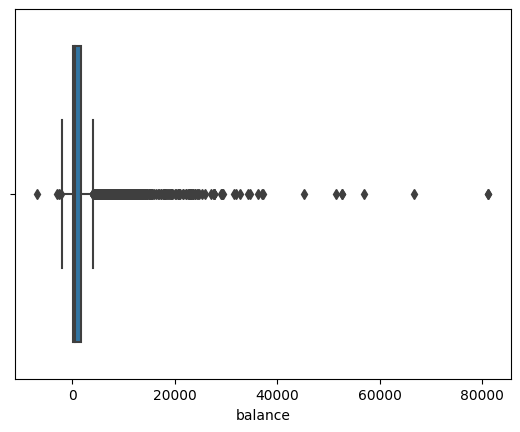

In [8]:
# Удаляем выбросы для признака balance - Вариант 1
# визуализируем выбросы
sns.boxplot(data=df,
            x='balance')

In [9]:
# Найдем границы и отфильтруем значения так, чтобы выбросов в данных не осталось.
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1 = np.percentile(x,25)
    quartile_3 = np.percentile(x,75)
    iqr = quartile_3 - quartile_1
    L = left*iqr
    R = right*iqr
    lower_bound = quartile_1 - L
    upper_bound = quartile_3 + R
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print('Lower bound :{}'.format(lower_bound))
print('Upper bound :{}'.format(upper_bound))


Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Lower bound :-2241.0
Upper bound :4063.0


<Axes: xlabel='balance'>

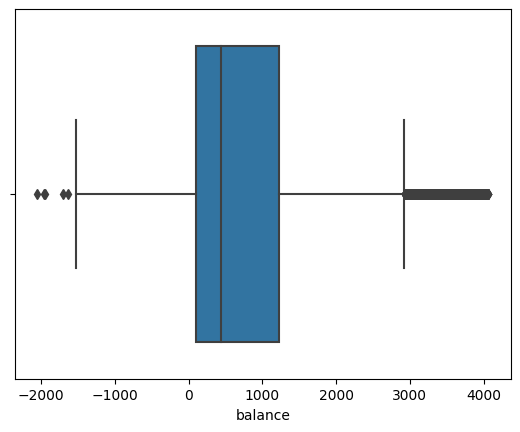

In [10]:
# визуализируем выбросы после очистки от выбросов
sns.boxplot(data=cleaned,
            x='balance')

ВЫВОД: Наблюдаем более плтное распределение данных...

## Часть 2:  Разведывательный анализ

### Задание 1

In [11]:
# Изучим соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируем результат


In [12]:
# Задание 3.1 Сколько клиентов открыли депозит? = > 4681
cleaned['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

Text(0, 0.5, 'Количество')

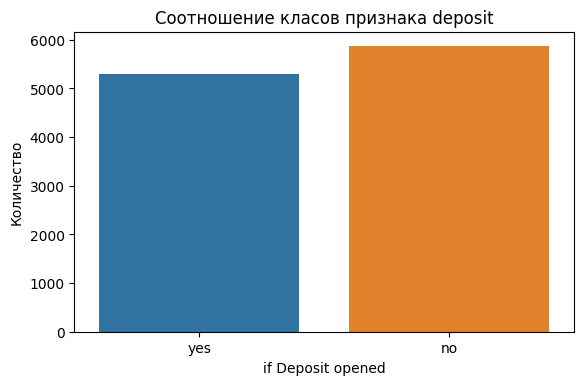

In [13]:
# Визуализируем признак deposit...
fig = plt.figure(figsize=(5, 3))
axes = fig.add_axes([0, 0, 1, 1])

sns.countplot(data=df,
              x='deposit',
              )

axes.set_title('Соотношение класов признака deposit')
axes.set_xlabel('if Deposit opened'),
axes.set_ylabel('Количество')

ВЫВОД: Соотношение классов в признаке - приемлимое..

In [14]:
# Задание 3.2 Каков максимальный возраст клиента банка? = > 95
cleaned.age.describe()

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Text(0, 0.5, 'Количество')

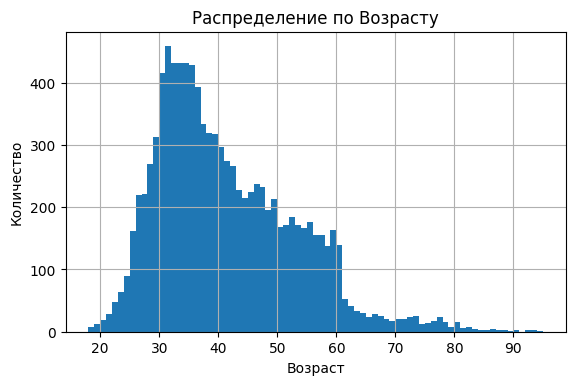

In [15]:
# посмотрим на распределение по признаку Возраст...
fig = plt.figure(figsize=(5, 3))
axes = fig.add_axes([0, 0, 1, 1])

cleaned['age'].hist(bins=max(cleaned['age'])-min(cleaned['age']))
axes.set_title('Распределение по Возрасту')
axes.set_xlabel('Возраст'),
axes.set_ylabel('Количество')

In [16]:
# Задание 3.3 Какова минимальная продолжительность разговора с клиентом банка? => 2 seconds
df.duration.describe()

count    11162.000000
mean       371.993818
std        347.128386
min          2.000000
25%        138.000000
50%        255.000000
75%        496.000000
max       3881.000000
Name: duration, dtype: float64

### Задания 2 и 3

In [18]:
# Воспользуемся пакетным решением для обзора данных...
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

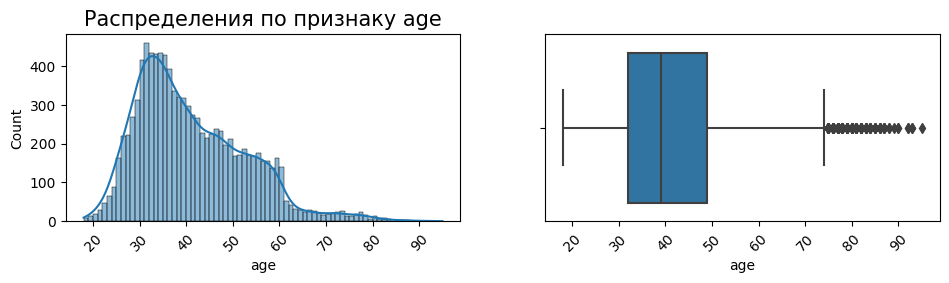

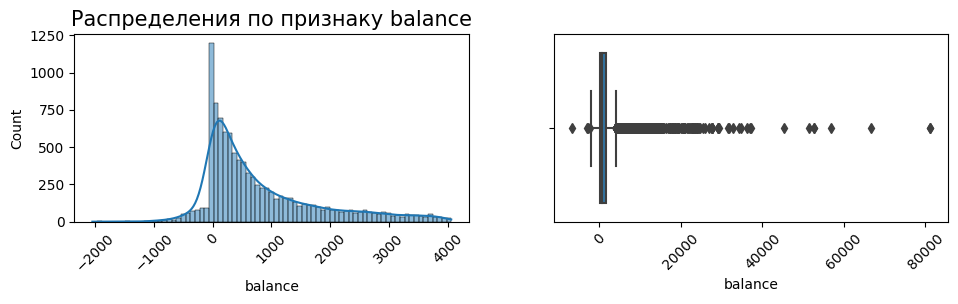

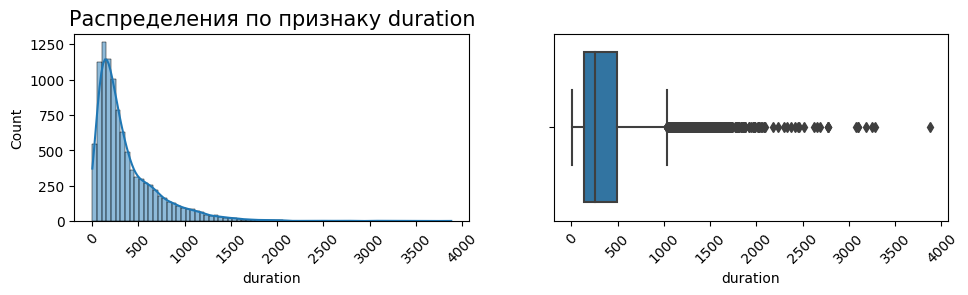

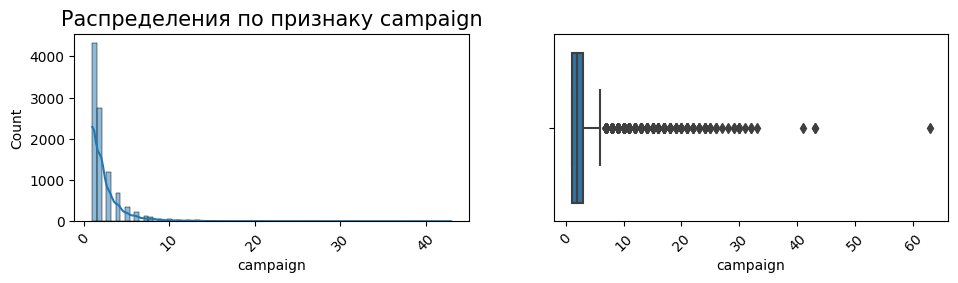

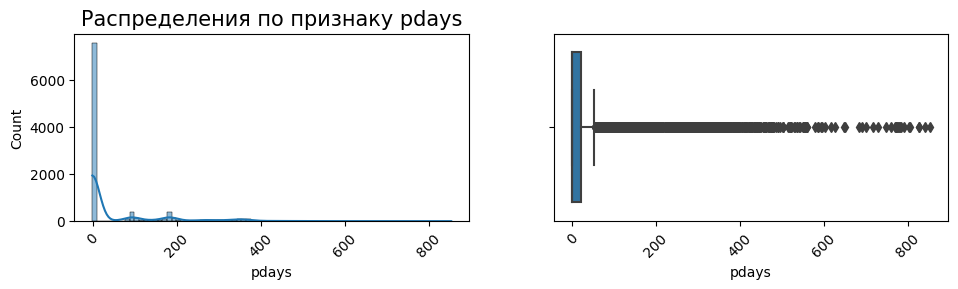

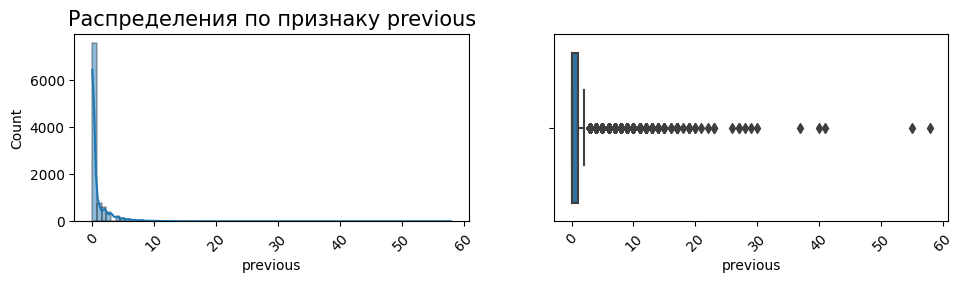

In [19]:
# Циклом визуализируем Числовые признаки...
for i in num_columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    fig.tight_layout(pad=3)
    sns.histplot(data=cleaned,x=str(i),bins=max(cleaned['age'])-min(cleaned['age']),kde=True,ax=axes[0])
    axes[0].set_title('Распределения по признаку {}'.format(i), fontsize=15)
    sns.boxplot(data=df,x=str(i),ax=axes[1])
    axes[0].xaxis.set_tick_params(rotation=45)
    axes[1].xaxis.set_tick_params(rotation=45)

### Задания 4 и 5

In [57]:
# Задание 3.4 Сколько было месяцев, в которых проводилась маркетинговая кампания? => 12
print('Маркетинговая компания проводилась во все {} месяцев'.format(len(cleaned.month.value_counts())))

Маркетинговая компания проводилась во все 12 месяцев


Сфер занятости - 11


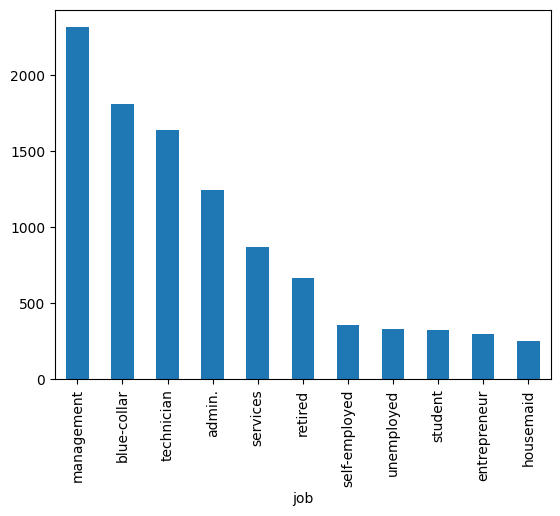

In [58]:
# Задание 3.5 Сколько сфер занятости представлено среди клиентов банка? => 11
a = cleaned.job.value_counts()
a.plot(kind='bar')
print('Сфер занятости - {}'.format(len(cleaned.job.value_counts())))

### Задание 6

<Axes: xlabel='poutcome'>

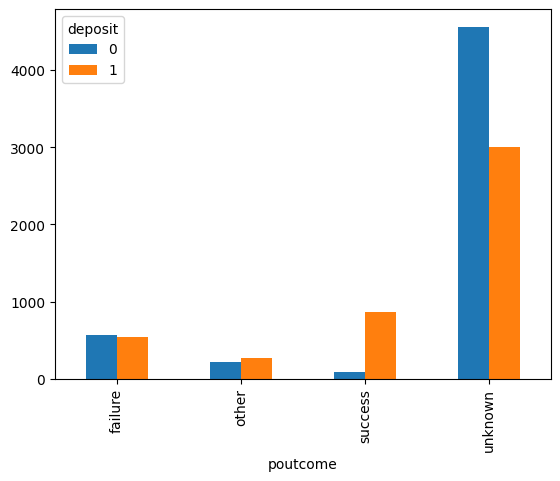

In [59]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач. = > success

a = cleaned.groupby('poutcome')['deposit'].value_counts(False).unstack()
a.plot(kind='bar', stacked=False)

### Задание 7

<Axes: >

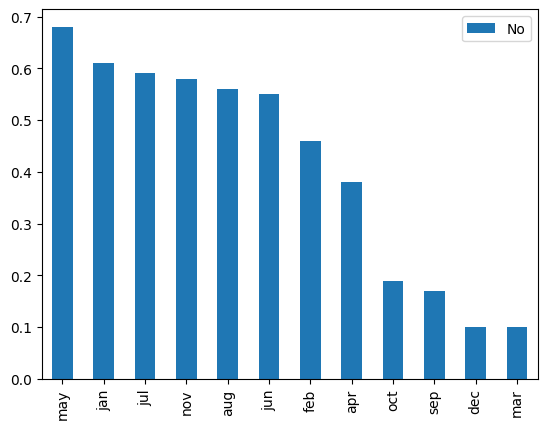

In [24]:
# Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит

a = cleaned.groupby('month')['deposit'].value_counts(False).unstack()

# создадим пустой словарь для сбора информации и пройдемся циклом по каждому месяцу
month_dict={}
for i in a.index:
    yes = a.loc[i]['yes']
    no = a.loc[i]['no']
    resp = no/(yes+no)
    month_dict[i] = float(round(resp,2))

# преобразуем словаь в датафрейм для удобства визуализации и построим график... => may
mdf = pd.DataFrame.from_dict(month_dict, orient='index',columns = ['No']).sort_values(by='No',ascending=False)
mdf.plot(kind='bar')

### Задание 8

In [25]:
# Создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_group'] = pd.cut(cleaned.age, bins=[0,30,40,50,60,9999], labels=['<30','30-40','40-50','50-60','60+'])
cleaned['age_group']

0        50-60
1        50-60
2        40-50
3        50-60
4        50-60
         ...  
11157    30-40
11158    30-40
11159    30-40
11160    40-50
11161    30-40
Name: age_group, Length: 10105, dtype: category
Categories (5, object): ['<30' < '30-40' < '40-50' < '50-60' < '60+']

### Задания 9 и 10

<Axes: xlabel='marital'>

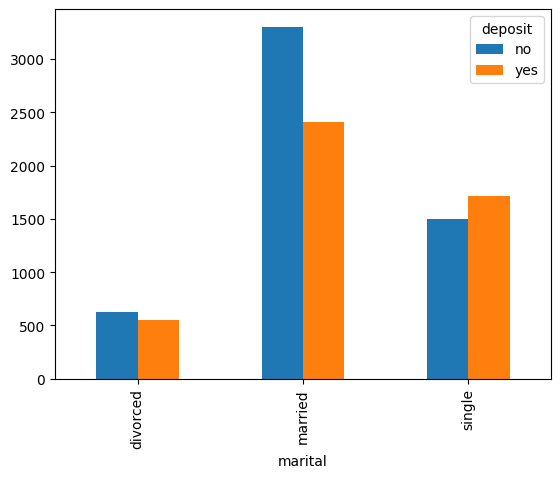

In [26]:
# Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
a = cleaned.groupby('marital')['deposit'].value_counts(False).unstack()
a.plot(kind='bar', stacked=False)

<Axes: xlabel='education'>

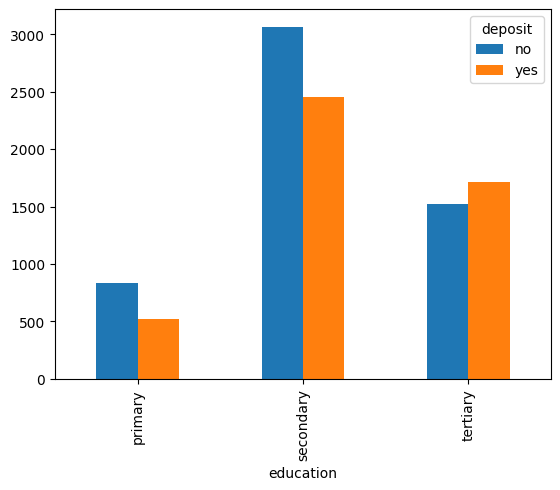

In [27]:
# Построим визуализации для открывших и неоткрывших депозит в зависимости от образования
a = cleaned.groupby('education')['deposit'].value_counts(False).unstack()
a.plot(kind='bar', stacked=False)

<Axes: xlabel='job'>

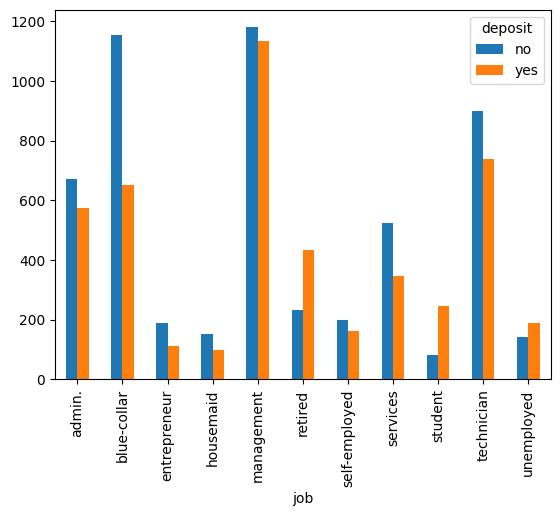

In [28]:
# Построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
a = cleaned.groupby('job')['deposit'].value_counts(False).unstack()
a.plot(kind='bar', stacked=False)

### Задание 11

In [29]:
# Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
cleaned_yes = cleaned[cleaned['deposit'] =='yes']
cleaned_no = cleaned[cleaned['deposit'] =='no']
print(cleaned_yes.shape,cleaned_no.shape)


(4681, 18) (5424, 18)


<Axes: xlabel='education', ylabel='marital'>

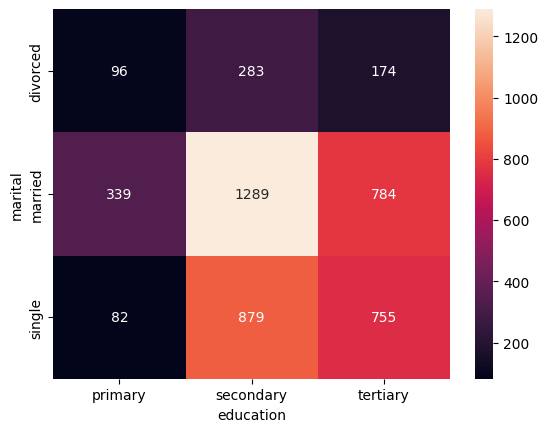

In [30]:
# Разделяю данные по признаку deposit - yes/no
cleand_yes_pvt = cleaned_yes.pivot_table(values='deposit',index='marital',columns='education',aggfunc='count')
cleand_no_pvt = cleaned_no.pivot_table(values='deposit',index='marital',columns='education',aggfunc='count')

# Построим тепловую карту соотношений между Семейным положением и Образованием для Положительного выбора... 
sns.heatmap(cleand_yes_pvt,annot=True, fmt='.0f')

<Axes: xlabel='education', ylabel='marital'>

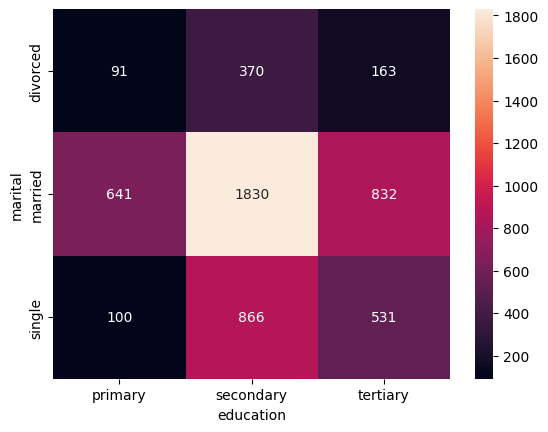

In [31]:
# Построим тепловую карту соотношений между Семейным положением и Образованием для Отрицательного выбора... 
sns.heatmap(cleand_no_pvt,annot=True, fmt='.0f')

## Часть 3: преобразование данных

### Задание 1

In [32]:
# Преобразуем уровни образования
lbl_coder = preprocessing.LabelEncoder()
cleaned.education = lbl_coder.fit_transform(cleaned.education)
cleaned.education.sum()

11995

In [33]:
# Сделаем тоже самое для age_group (возрастных групп)
cleaned.age_group = lbl_coder.fit_transform(cleaned.age_group)

### Задания 2 и 3

In [34]:
# Преобразуем бинарные переменные в представление из нулей и единиц
# Перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

binarizer = preprocessing.LabelBinarizer()
cleaned.deposit = binarizer.fit_transform(cleaned.deposit)

In [35]:
# Вычислите стандартное отклонение для преобразованной в корректный вид целевой переменной
deposit_std = np.std(cleaned.deposit)
round(deposit_std,3)

0.499

In [36]:
# Сделаем то же самое для других бинарных переменных, которых у нас три: 'default';'housing';'loan'.
cleaned.default = binarizer.fit_transform(cleaned.default)
cleaned.housing = binarizer.fit_transform(cleaned.housing)
cleaned.loan = binarizer.fit_transform(cleaned.loan)

default_avg = np.mean(cleaned.default)
housing_avg = np.mean(cleaned.housing)
loan_avg = np.mean(cleaned.loan)

round(default_avg+housing_avg+loan_avg,3)

0.635

### Задание 4

In [37]:
# создадим дамми-переменные...

cols=['job','marital','contact','month','poutcome']
dum_cleaned = pd.get_dummies(cleaned,columns=cols)
dum_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int32  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int32  
 5   loan               10105 non-null  int32  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int32  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

In [38]:
# построим корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = dum_cleaned.corr()
corr.sort_values(by='deposit')
sorted_matrix = corr.unstack().sort_values()

# посмотрим на максимальное значение в мартице
max(sorted_matrix[(sorted_matrix > 0)&(sorted_matrix<1)])


0.6087193145248583

Вывод: максимальное значение в мартице ниже 0.9 - мультиколлинеарности нет!

### Задания 7 и 8

In [39]:
# выделим целевую переменную - deposit
X = dum_cleaned.drop(['deposit'], axis=1)
y = dum_cleaned['deposit']

# разделим наши данные
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)


In [40]:
# Каким получился размер тестовой выборки? => 3335
X_test.shape

(3335, 45)

In [41]:
# Каково среднее значение целевой переменной на тестовой выборке? => 0.46
round(np.mean(y_test),2)

0.46

### Задание 9

In [42]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
best_cols = selector.get_feature_names_out()

### Задание 10

In [43]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[best_cols])
X_train_scaled = scaler.transform(X_train[best_cols])
X_test_scaled = scaler.transform(X_test[best_cols])
round(X_test_scaled[:, 0].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [44]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr = LogisticRegression(solver='sag',random_state=42, max_iter=1000)
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)

print(round(metrics.accuracy_score(y_test,y_pred),2))

0.81


### Задания 2,3,4

In [45]:
# Проследим на графике, как развивается метрика Accuracy в зависимости от max_depth (глубинs дерева)
deps = np.linspace(1,16,16,dtype='int')
acc = [] # пустой список для сбора поазателей...

''' Функция, обучающая модель DecisionTreeClassifier по изменяемому параметру max_depth=i
    Args:
        deps: диапазон значений для max_depth
    Returns:
        значение Accuracy для Тренировочной и Тестовой выборки для модели DecisionTreeClassifier
'''

def tri_func(arg):
    dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=i)
    dt.fit(X_train_scaled,y_train)
    y_pred_test = dt.predict(X_test_scaled)
    y_pred_train = dt.predict(X_train_scaled)
    return [round(metrics.accuracy_score(y_test,y_pred_test),7),round(metrics.accuracy_score(y_train,y_pred_train),7)]

# собираем показатели для тренировочной и тестовой выборки...
for i in deps:
    acc.append([i,tri_func(i)])

# переименуем столбцы...
df_acc = pd.DataFrame(acc,columns=['Depth','Accuracy'])

# создадим новые столбцы...
df_acc['Acc_test'] = ''
df_acc['Acc_train'] = ''
df_acc['Delta'] = ''

# заполним значениями, в том числе и разницу между Accurcy теста и тренирови...
for i in df_acc.index:
    df_acc.Acc_test.loc[i] = df_acc.Accuracy.loc[i][0]
    df_acc.Acc_train.loc[i] = df_acc.Accuracy.loc[i][1]
    df_acc.Delta.loc[i] = df_acc.Acc_train.loc[i] - df_acc.Acc_test.loc[i]

# удалим ненужный признак...
df_acc = df_acc.drop('Accuracy',axis=1)
df_acc.head(10)


Depth  Acc_test Acc_train     Delta
0      1  0.706447  0.711521  0.005075
1      2  0.717841  0.728804  0.010962
2      3  0.770315  0.775775  0.005461
3      4  0.769715  0.775923  0.006208
4      5  0.793703   0.80384  0.010137
5      6  0.806597  0.818021  0.011424
6      7  0.814993  0.836632   0.02164
7      8  0.812894  0.840916  0.028022
8      9  0.806897  0.851403  0.044507
9     10       0.8  0.858936  0.058936

In [46]:
# ... и выведем информацию на график
px.line(data_frame=df_acc,
        x='Depth',
        y=['Acc_test','Acc_train','Delta'],
        title='Dependancy of Accuracy from Depth of Tree for Test & Train sets',
        )


**ВЫВОД:** Не смотря на то, что показатель теста максимальный при глубине дерева в 7, разница с тренировочный Accuracy растет также, то есть эффективность теста падает => стало быть примем 6 за самый оптимальный показатель глубины дерева для нашей модели...

### Задание 5

In [47]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
            'max_depth':[3,5,7]
            }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=param_grid, 
    cv=3,
    scoring=('f1'),
    return_train_score=True)

grid_search.fit(X_train_scaled,y_train)
y_pred = grid_search.predict(X_test_scaled)

print('F1 equals: {}'.format(round(metrics.f1_score(y_test,y_pred),3)))
grid_search.best_params_

F1 equals: 0.803


{'max_depth': 7, 'min_samples_split': 2}

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [48]:
# Обучим на наших данных Случайный Лес
# Создаём объект класса RandomForestClassifier
rf = ensemble.RandomForestClassifier(
    n_estimators = 100, #число деревьев
    criterion = 'gini', #критерий эффективности
    min_samples_leaf = 5, #максимальная глубина дерева
    max_depth = 10,
    random_state = 42 #генератор случайных чисел
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_test1 = rf.predict(X_test_scaled)
#Выводим отчёт о метриках
print('Accuracy equals to: {}'.format(round(metrics.accuracy_score(y_pred_test1,y_pred),2)))
print('Recall equals to: {}'.format(round(metrics.recall_score(y_pred_test1,y_pred),2)))

Accuracy equals to: 0.96
Recall equals to: 0.95


### Задания 2 и 3

In [49]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test_scaled)

# Оцениваем качество по метрике MSE
print(f'F1 для Gradient Boosting Classifier составляет : {round(metrics.f1_score(y_test, gb_pred),2)}')


F1 для Gradient Boosting Classifier составляет : 0.82


**ВЫВОД:** эффективность Случайного лЕса оказалась выше...

### Задание 4

In [50]:
# Объединим уже известные нам алгоритмы с помощью стекинга...

estimators = [('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42 #генератор случайных чисел
    )
),
        ('lr', LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000)),
        
        ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

st_pred = stack.predict(X_test_scaled)

print(f'Precision для Stacking Classifier составляет : {round(metrics.precision_score(y_test, st_pred),2)}')

Precision для Stacking Classifier составляет : 0.81


### Задание 5

In [51]:
# Отберем 3 самые важные признака с помощбю SelectKBest...

from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [52]:
# Реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.6.0


In [53]:
# задаем пространства поиска гиперпараметров
random_state = 42
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_test, model.predict(X_test_scaled))
    return score

In [54]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-03-29 13:29:15,716] A new study created in memory with name: RandomForestClassifier
[I 2024-03-29 13:29:16,749] Trial 0 finished with value: 0.8187834856602585 and parameters: {'n_estimators': 193, 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8187834856602585.
[I 2024-03-29 13:29:17,770] Trial 1 finished with value: 0.8170616113744077 and parameters: {'n_estimators': 186, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8187834856602585.
[I 2024-03-29 13:29:18,886] Trial 2 finished with value: 0.8205289672544082 and parameters: {'n_estimators': 172, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8205289672544082.
[I 2024-03-29 13:29:19,951] Trial 3 finished with value: 0.8184110970996217 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8205289672544082.
[I 2024-03-29 13:29:21,040] Trial 4 finished with value: 0.8204158790170132 and parameters: {'n_

CPU times: total: 17.1 s
Wall time: 18.2 s


In [55]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 155, 'max_depth': 18, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.82


In [56]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


**ВЫВОД:** Optuna позволила нам улучшить предыдущий показатель F1 от стекинга c 0.81 => 0.82.